<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/DLS_Stepik/11_GANs/archive'

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
def get_dataloader(image_size, batch_size, data_dir, stats):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object
    """
    train_ds = ImageFolder(data_dir, transform=tt.Compose([
        tt.Resize(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)]))

    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

    return train_dl

In [ ]:
image_size = 128
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

dl = get_dataloader(image_size, batch_size, DATA_DIR, stats)
#TODO: build dataloader and transfer it to device

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

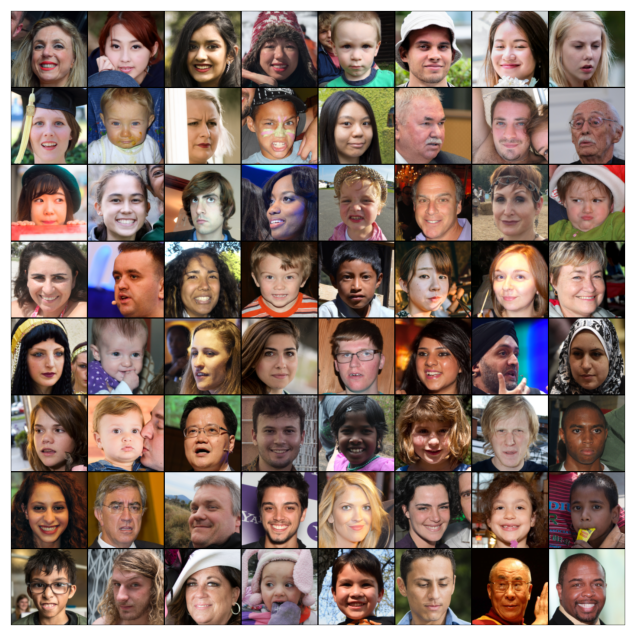

In [ ]:
show_batch(dl)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
train_dl = DeviceDataLoader(dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128
    nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 64 x 64

    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

Output Size=(Input Size−1)×Stride−2×Padding+Kernel Size

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class ImprovedGenerator(nn.Module):
    def __init__(self, latent_size):
        super(ImprovedGenerator, self).__init__()
        self.init_size = 16  # Adjusting the initial size for 128x128 output
        self.l1 = nn.Sequential(nn.Linear(latent_size, 512 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            ResidualBlock(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            ResidualBlock(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            ResidualBlock(64),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Output channel is 3 for RGB images
        )

    def forward(self, z):
        out = self.l1(z.view(z.size(0), -1))
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

latent_size = 100
generator = ImprovedGenerator(latent_size)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

torch.Size([128, 3, 128, 128])


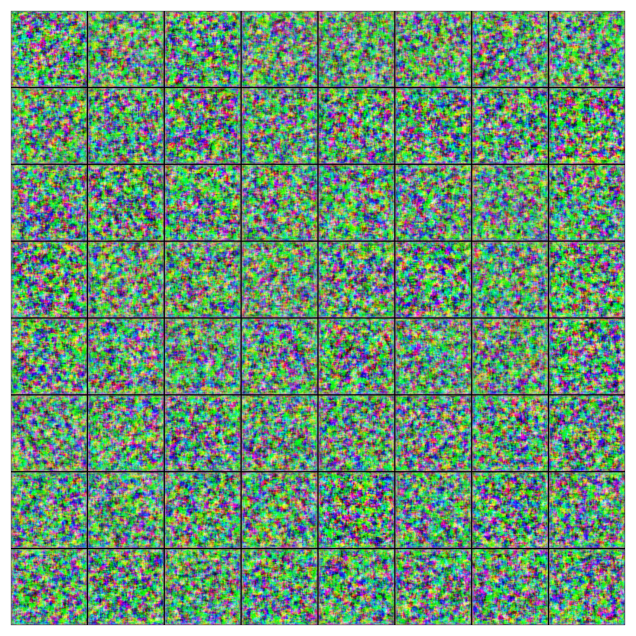

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
epochs = 15

In [ ]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/15], loss_g: 4.4459, loss_d: 0.6334, real_score: 0.8263, fake_score: 0.2025


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/15], loss_g: 4.1035, loss_d: 0.8349, real_score: 0.7486, fake_score: 0.2251


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/15], loss_g: 3.2751, loss_d: 0.7755, real_score: 0.7657, fake_score: 0.2473


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/15], loss_g: 3.2591, loss_d: 0.8020, real_score: 0.7470, fake_score: 0.2634


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/15], loss_g: 3.1809, loss_d: 0.9832, real_score: 0.6959, fake_score: 0.2860


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/15], loss_g: 3.6107, loss_d: 0.8978, real_score: 0.7295, fake_score: 0.2912


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/15], loss_g: 2.7068, loss_d: 0.8868, real_score: 0.6968, fake_score: 0.2855


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/15], loss_g: 3.0227, loss_d: 0.8018, real_score: 0.7289, fake_score: 0.2744


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/15], loss_g: 3.0269, loss_d: 0.8673, real_score: 0.7194, fake_score: 0.2765


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/15], loss_g: 2.8216, loss_d: 0.8856, real_score: 0.7050, fake_score: 0.2843


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/15], loss_g: 2.6234, loss_d: 0.8982, real_score: 0.6973, fake_score: 0.2964


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/15], loss_g: 2.7509, loss_d: 0.8253, real_score: 0.7132, fake_score: 0.2809


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/15], loss_g: 2.7749, loss_d: 0.8100, real_score: 0.7238, fake_score: 0.2874


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/15], loss_g: 2.7536, loss_d: 0.8262, real_score: 0.7126, fake_score: 0.2732


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/15], loss_g: 2.6770, loss_d: 0.8668, real_score: 0.7167, fake_score: 0.2878
Saving generated-images-0015.png


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
torch.save(generator.state_dict(), 'Generator')
torch.save(discriminator.state_dict(), 'Discriminator')

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

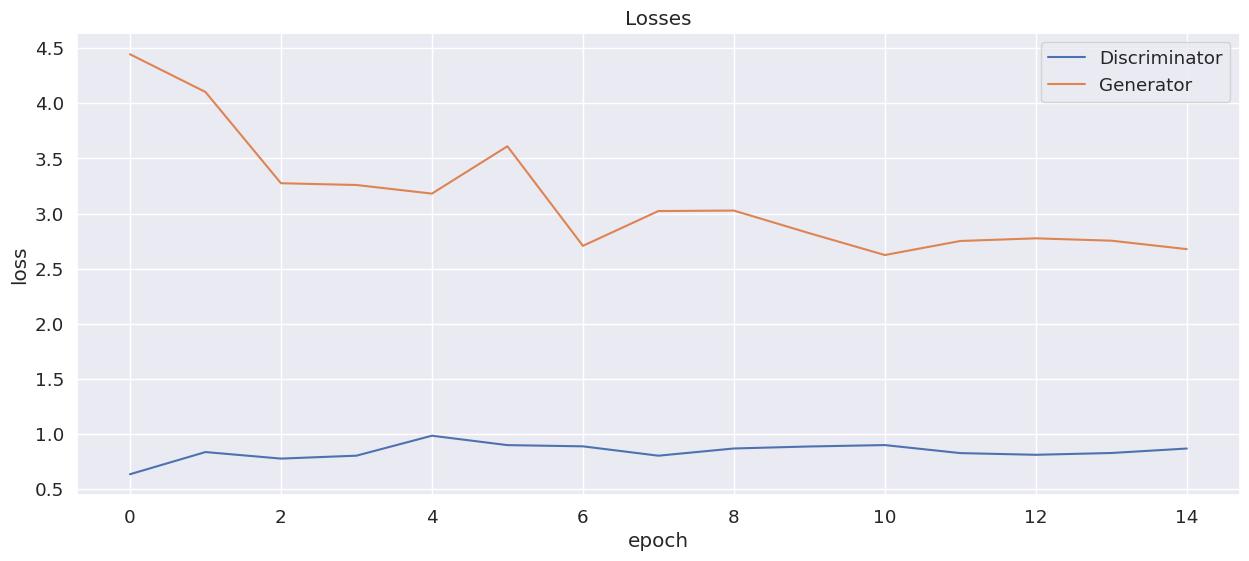

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

**График потерь**


На графике видно, что потери дискриминатора уменьшаются и стабилизируются, что говорит о его улучшении в различении настоящих и поддельных изображений. Потери генератора колеблются и в целом идут на убыль, указывая на то, что он становится лучше в создании правдоподобных изображений. Однако, генератор теряет стабильность, что может потребовать корректировки параметров обучения. Также важно продолжать обучение и визуально оценивать генерируемые изображения для подтверждения качества и разнообразия.

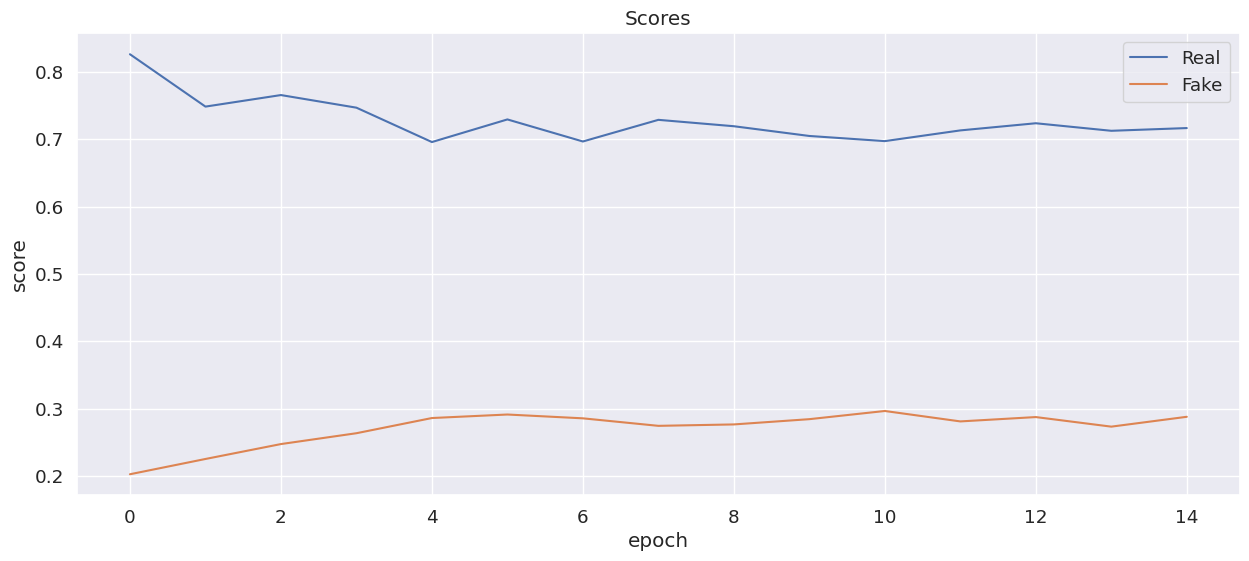

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [ ]:
def show_images(generated):
    generated = (generated + 1) / 2
    generated = generated.clamp(0, 1)
    generated = generated.to('cpu')
    n_images = generated.size(0)
    plt.figure(figsize=(n_images * 2, 2))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.axis('off')
        plt.imshow(tt.ToPILImage()(generated[i]))
    plt.show()

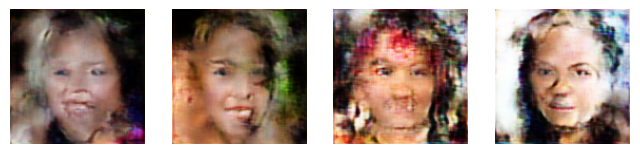

In [ ]:
show_images(fake_images)

Как вам качество получившихся изображений?

**Оценка качества изображений**

Качество изображений невысокое: лица размыты, детали слабо различимы, и цвета выглядят неестественно. Это может указывать на необходимость дальнейшей настройки и обучения генеративной сети.

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
folder_path = '/content/drive/MyDrive/Colab Notebooks/DLS_Stepik/11_GANs/archive/faces_dataset_small'
num_images = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])

print(f"Number of images in the folder: {num_images}")

Number of images in the folder: 3143


In [ ]:
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from collections import Counter
import plotly.express as px

In [ ]:
discriminator =  to_device(discriminator, device)
discriminator.load_state_dict(torch.load('/content/Discriminator'))

generator =  to_device(generator, device)
generator.load_state_dict(torch.load('/content/Generator'))

<All keys matched successfully>

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/DLS_Stepik/11_GANs/archive'

In [ ]:
def get_flatten(image_size, loader='train'):
    train = ImageFolder(DATA_DIR,
                        transform=tt.Compose([
                                    tt.Resize(image_size),
                                    tt.ToTensor(),
                                    tt.Normalize(*stats)],))

    train_loader = DataLoader(train, 1, shuffle=True, num_workers=2, pin_memory=True)
    table = []
    print('label 1')
    for batch, _ in tqdm(train_loader):
        batch = batch.permute(0, 2, 3, 1).flatten().cpu().numpy()
        sample = {f"pix_{i}": pix for i, pix in enumerate(batch)}
        sample['label'] = 1
        table.append(sample)

    print('label 0')
    for i in tqdm(range(len(train_loader))):
        fixed_latent = torch.randn(1, latent_size, 1, 1, device=device)
        fake_images = generator(fixed_latent)
        fake_images = fake_images.detach().permute(0, 2, 3, 1).flatten().cpu().numpy()
        sample = {f"pix_{i}": pix for i, pix in enumerate(fake_images)}
        sample['label'] = 0
        table.append(sample)

    table = pd.DataFrame(table)
    table['label'] = table['label'].astype(str)
    table = shuffle(table, random_state=42)
    print('Data is created')
    return table

In [ ]:
def check_img(data):
    features = data.drop('label', axis=1)
    feat = shuffle(features, random_state=42)
    X_ = np.array(feat)
    X_t = X_.reshape(X_.shape[0], 128, 128, 3)

    fig = plt.figure(figsize=(8,8))

    for i in range(16):
        fig.add_subplot(4, 4, i+1)
        plt.imshow(np.clip((X_t[i] *.5 + .5), 0, 1))
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

In [ ]:
image_size = 128
batch_size = 64

train_loader = get_dataloader(image_size, batch_size, DATA_DIR, stats)

In [ ]:
X_train = get_flatten(image_size)

label 1


  0%|          | 0/3143 [00:00<?, ?it/s]

label 0


  0%|          | 0/3143 [00:00<?, ?it/s]

Data is created


In [ ]:
X_train.head()

,pix_0,pix_1,pix_2,pix_3,pix_4,pix_5,pix_6,pix_7,pix_8,pix_9,...,pix_49143,pix_49144,pix_49145,pix_49146,pix_49147,pix_49148,pix_49149,pix_49150,pix_49151,label
4441,-0.154081,-0.055429,-0.207460,-0.117772,-0.126585,-0.154592,-0.074059,-0.234504,-0.055455,-0.111256,...,0.849746,0.866947,0.905739,0.750279,0.626436,0.754113,0.587388,0.452781,0.457989,0
3658,0.321315,0.224535,-0.074370,0.462978,0.148510,0.260266,0.614701,0.204224,0.501582,0.743863,...,0.067386,0.424453,0.621959,0.162294,0.245448,0.377120,0.264361,0.103373,0.270551,0
6066,0.699902,0.310702,-0.166443,0.644388,0.274864,-0.041149,0.710083,0.299789,0.095603,0.771582,...,-0.411195,-0.279101,-0.242620,-0.357799,-0.370066,-0.381986,-0.291231,-0.480941,-0.422064,0
5041,0.038828,0.216284,0.029974,0.186867,0.183216,0.254916,0.209080,0.135623,0.359000,0.353937,...,-0.404808,-0.287392,-0.305995,-0.336326,-0.368108,-0.450487,-0.215614,-0.377277,-0.371426,0
1539,0.262745,0.262745,0.325490,0.254902,0.254902,0.317647,0.262745,0.262745,0.325490,0.254902,...,0.301961,-0.129412,-0.286274,0.286275,-0.145098,-0.301961,0.294118,-0.137255,-0.294118,1


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6286 entries, 4441 to 860
Columns: 49153 entries, pix_0 to label
dtypes: float32(49152), object(1)
memory usage: 1.2+ GB


In [ ]:
# X_train.to_csv('X_train.csv', index=False)

In [ ]:
X_train['label'].value_counts(normalize=True)

0    0.5
1    0.5
Name: label, dtype: float64

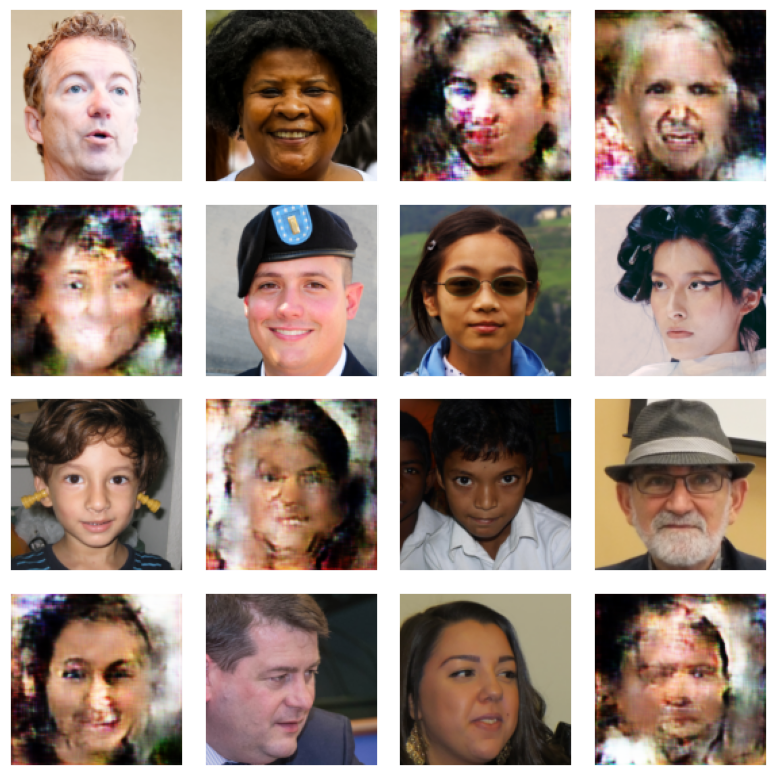

In [ ]:
check_img(X_train)

In [ ]:
X_subset = X_train.drop('label', axis=1).iloc[:300]
y_subset = X_train[['label']].iloc[:300]

In [ ]:
loo = LeaveOneOut()
neigh = KNeighborsClassifier(n_neighbors=1)

y_true, y_pred = list(), list()

with tqdm(desc='Iter.', total=len(X_subset)) as pbar_outer:
    for train_idx, test_idx in loo.split(X_subset):
        train_X, test_X = X_subset.iloc[train_idx], X_subset.iloc[test_idx]
        train_y, test_y = y_subset.iloc[train_idx], y_subset.iloc[test_idx]

        neigh.fit(train_X, train_y.values.ravel())
        y_preds = neigh.predict(test_X)

        y_true.append(test_y.iloc[0])
        y_pred.append(y_preds[0])
        pbar_outer.update(1)

acc = accuracy_score(y_true, y_pred)
print(f'Accuracy for features: {acc:.3f}')

Iter.:   0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for features: 0.750


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

**Оценка Accuracy**

Мы стремимся получить Accuracy на уровне 0.5, что будет говорить о высоком качестве генерируемых изображений. сравнимых с реальными картинками. Качество 0.75 говорит о том, что дескриминатору удается с большой долей верояитности отличить сгенерированную картинку от настоящей.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X_subset)

In [ ]:
y_subset['text_label'] = np.where(y_subset == '1', 'Real', 'Generated')

In [ ]:
fig = px.scatter(X_embedded, x = 0, y = 1,
           color=y_subset['text_label'], opacity=0.84,
                 labels={
                     'color': "Class "
                 },
                title="Feature distribution by class, t-SNE")\
.for_each_trace(lambda t: t.update(name=t.name.replace("=",": ")))

fig.update_traces(marker=dict(size=10,
                              line=dict(width=2)),
                selector=dict(mode='markers'))
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(visible=False, showticklabels=False)
fig.show();

Прокомментируйте получившийся результат:

**График распределений**

На предоставленной визуализации видно, что распределения реальных и сгенерированных изображений частично перекрываются. Однако, некоторые кластеры реальных и сгенерированных данных отделены друг от друга, что может указывать на то, что генератор создаёт изображения, которые всё же отличаются от реальных. Это может свидетельствовать о потребности в дальнейшем улучшении модели генератора для создания более реалистичных изображений.